In [ ]:
!pip install diffusers transformers accelerate safetensors
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118
!pip install gradio pillow

Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image
import json
from datetime import datetime

class ImageGenerator:
    def __init__(self):
        print(" Loading model...")

        
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f" Using device: {self.device}")

        self.pipe = StableDiffusionPipeline.from_pretrained(
            "runwayml/stable-diffusion-v1-5",
            torch_dtype=torch.float16,
            safety_checker=None  
        )

        self.pipe = self.pipe.to(self.device)

        self.pipe.enable_attention_slicing()

        print("✅ Model loaded successfully!")

    def generate(self, prompt, negative_prompt="", num_images=1,
                 steps=30, guidance_scale=7.5, seed=None):


        generator = None
        if seed is not None:
            generator = torch.Generator(device=self.device).manual_seed(seed)

        print(f"Generating {num_images} image(s)...")

        images = self.pipe(
            prompt=prompt,
            negative_prompt=negative_prompt,
            num_images_per_prompt=num_images,
            num_inference_steps=steps,
            guidance_scale=guidance_scale,
            height=512,
            width=512,
            generator=generator
        ).images

        print(f" Generated {len(images)} image(s)!")

        return images

print("=" * 50)
print("Initializing AI Image Generator...")
print("=" * 50)

generator = ImageGenerator()

print("\n" + "=" * 50)
print("MOdel loded!")
print("=" * 50)

Initializing AI Image Generator...
 Loading model...
 Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


✅ Model loaded successfully!

MOdel loded!


CREATING A GRADIO WEB INTERFACE 

In [ ]:
import gradio as gr
import os

# Content filtering 
BLOCKED_WORDS = ['nsfw', 'nude', 'naked', 'explicit', 'violence', 'gore', 'sexual']

def is_safe_prompt(prompt):
    """Check if prompt is safe"""
    prompt_lower = prompt.lower()
    for word in BLOCKED_WORDS:
        if word in prompt_lower:
            return False, f"⚠️ Prompt contains inappropriate content: '{word}'"
    return True, "Safe"

# some sample prompts
STYLE_TEMPLATES = {
    "Realistic": "photorealistic, high quality, detailed, 8k resolution, professional photography",
    "Artistic": "digital art, artstation, detailed, masterpiece, trending on artstation",
    "Anime": "anime style, high quality, detailed, studio ghibli style",
    "Oil Painting": "oil painting, classical art, detailed brushstrokes, museum quality",
    "Sketch": "pencil sketch, detailed line art, artistic, hand drawn",
    "3D Render": "3d render, octane render, highly detailed, photorealistic",
    "Watercolor": "watercolor painting, soft colors, artistic, detailed"
}

def enhance_prompt(prompt, style):
    if style in STYLE_TEMPLATES:
        return f"{prompt}, {STYLE_TEMPLATES[style]}"
    return prompt

def generate_images(prompt, style, negative_prompt, num_images, steps, guidance, seed, enhance):

    try:
        is_safe, message = is_safe_prompt(prompt)
        if not is_safe:
            return None, message

        final_prompt = enhance_prompt(prompt, style) if enhance else prompt

        if not negative_prompt:
            negative_prompt = "blurry, low quality, distorted, ugly, duplicate, mutated, deformed"

        seed_value = None if seed == -1 else int(seed)

        print(f"\n{'='*60}")
        print(f"📝 Original Prompt: {prompt}")
        if enhance:
            print(f"✨ Enhanced Prompt: {final_prompt}")
        print(f"🎨 Style: {style}")
        print(f"🚫 Negative: {negative_prompt}")
        print(f"⚙️ Steps: {steps}, Guidance: {guidance}, Seed: {seed_value}")
        print(f"{'='*60}\n")

        images = generator.generate(
            prompt=final_prompt,
            negative_prompt=negative_prompt,
            num_images=int(num_images),
            steps=int(steps),
            guidance_scale=guidance,
            seed=seed_value
        )

        # Save images with metadata
        save_images_with_metadata(images, prompt, final_prompt, {
            'style': style,
            'negative_prompt': negative_prompt,
            'steps': steps,
            'guidance_scale': guidance,
            'seed': seed_value
        })

        success_msg = f" Successfully generated {len(images)} image(s)!"
        return images, success_msg

    except Exception as e:
        error_msg = f" Error: {str(e)}"
        print(error_msg)
        return None, error_msg

def save_images_with_metadata(images, original_prompt, enhanced_prompt, params):
    """Save generated images with metadata"""
    os.makedirs('outputs', exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    for idx, img in enumerate(images):
        # Save image
        filename = f"outputs/img_{timestamp}_{idx}.png"
        img.save(filename)

        # Save metadata
        metadata = {
            "original_prompt": original_prompt,
            "enhanced_prompt": enhanced_prompt,
            "timestamp": timestamp,
            "parameters": params,
            "model": "Stable Diffusion 1.5",
            "resolution": "512x512"
        }

        metadata_file = f"outputs/img_{timestamp}_{idx}_metadata.json"
        with open(metadata_file, "w") as f:
            json.dump(metadata, f, indent=2)

    print(f" Saved {len(images)} image(s) to 'outputs' folder")

# Example prompts for users
example_prompts = [
    ["A serene mountain landscape with a crystal clear lake at sunset", "Realistic"],
    ["A cute robot reading a book in a cozy library", "Artistic"],
    ["Portrait of a wise old wizard with a long beard", "Oil Painting"],
    ["A futuristic cyberpunk city with neon lights at night", "3D Render"],
    ["A magical forest with glowing mushrooms and fireflies", "Artistic"],
]

# Create Gradio Interface
with gr.Blocks(title=" AI Image Generator", theme=gr.themes.Soft()) as demo:

    gr.Markdown("""
    #  AI-Powered Image Generator
    ### Generate stunning images from text descriptions using Stable Diffusion

    **Instructions:**
    1. Enter your text prompt describing the image you want
    2. Choose a style preset (optional)
    3. Adjust parameters for quality and creativity
    4. Click "Generate Images" and wait 10-30 seconds

    ⚠️ **Note:** First generation may take longer as the model warms up.
    """)

    with gr.Row():
        with gr.Column(scale=1):
            # Input controls
            prompt_input = gr.Textbox(
                label="📝 Prompt",
                placeholder="Describe the image you want to generate...",
                lines=3
            )

            style_input = gr.Dropdown(
                choices=list(STYLE_TEMPLATES.keys()),
                label=" Style Preset",
                value="Realistic"
            )

            negative_input = gr.Textbox(
                label=" Negative Prompt (Optional)",
                placeholder="Things to avoid in the image...",
                lines=2
            )

            with gr.Row():
                num_images_input = gr.Slider(
                    minimum=1, maximum=4, value=1, step=1,
                    label=" Number of Images"
                )

                enhance_checkbox = gr.Checkbox(
                    label=" Auto-enhance prompt",
                    value=True
                )

            with gr.Accordion(" Advanced Settings", open=False):
                steps_input = gr.Slider(
                    minimum=20, maximum=50, value=30, step=5,
                    label="Steps (Quality - Higher = Better but Slower)"
                )

                guidance_input = gr.Slider(
                    minimum=1, maximum=20, value=7.5, step=0.5,
                    label="Guidance Scale (7-12 recommended)"
                )

                seed_input = gr.Number(
                    label=" Seed (-1 for random)",
                    value=-1
                )

            generate_btn = gr.Button(" Generate Images", variant="primary", size="lg")

            gr.Markdown(" Example Prompts")
            gr.Examples(
                examples=example_prompts,
                inputs=[prompt_input, style_input]
            )

        with gr.Column(scale=1):
            # Output area
            output_gallery = gr.Gallery(
                label="Generated Images",
                columns=2,
                height=500
            )

            status_output = gr.Textbox(
                label="Status",
                lines=2,
                interactive=False
            )

            gr.Markdown("""
            ###  Download
            Click on any image to view full size, then right-click to save.
            Images are also saved to the 'outputs' folder with metadata.
            """)

    # Connect generate button to function
    generate_btn.click(
        fn=generate_images,
        inputs=[
            prompt_input, style_input, negative_input,
            num_images_input, steps_input, guidance_input,
            seed_input, enhance_checkbox
        ],
        outputs=[output_gallery, status_output]
    )

    gr.Markdown("""
    ---
    ###  Tips for Better Results:
    - **Be specific:** "A red sports car on a mountain road at sunset" is better than "a car"
    - **Use descriptive words:** Add adjectives like "detailed", "beautiful", "epic"
    - **Mention style:** "in the style of Van Gogh", "photorealistic", "anime style"
    - **Negative prompts:** Use to avoid unwanted elements like "blurry, low quality"
    - **Experiment:** Try different guidance scales and styles for varied results

    ###  Ethical Use:
    - Images are generated for creative and educational purposes
    - Do not generate harmful, offensive, or inappropriate content
    - AI-generated images should be clearly labeled as such
    - Respect copyright and don't try to replicate specific artworks
    """)

# Launch the interface
print("\n" + "="*60)
print(" Launching Web Interface...")
print("="*60 + "\n")

demo.launch(
    share=True,        # Creates public URL
    debug=True,        # Show errors
    show_error=True    # Display error messages
)

print("\n Interface is live! Use the link above to access it.")
print("💡 The 'share' link works from any device - even your phone!")


 Launching Web Interface...

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://3ac11241e02e076370.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://3ac11241e02e076370.gradio.live

 Interface is live! Use the link above to access it.
💡 The 'share' link works from any device - even your phone!


In [ ]:
# Cell 4 - Advanced Features & Utilities

import zipfile
from google.colab import files
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont

# 1. WATERMARKING FUNCTION
def add_watermark(image, text="AI Generated"):
    """Add watermark to image to indicate AI origin"""
    img_copy = image.copy()
    draw = ImageDraw.Draw(img_copy)

    # Get image size
    width, height = img_copy.size

    # Position watermark at bottom right
    text_position = (width - 150, height - 30)

    # Add semi-transparent text
    draw.text(text_position, text, fill=(255, 255, 255, 128))

    return img_copy

# 2. BATCH GENERATION FUNCTION
def generate_batch(prompts_list, style="Realistic", steps=30):
    """Generate multiple images from a list of prompts"""
    all_images = []

    print(f"\n🎨 Starting batch generation for {len(prompts_list)} prompts...\n")

    for idx, prompt in enumerate(prompts_list, 1):
        print(f"[{idx}/{len(prompts_list)}] Generating: {prompt[:50]}...")

        # Enhance prompt
        enhanced = enhance_prompt(prompt, style)

        # Generate image
        images = generator.generate(
            prompt=enhanced,
            negative_prompt="blurry, low quality, distorted",
            num_images=1,
            steps=steps,
            guidance_scale=7.5
        )

        all_images.extend(images)
        print(f"✅ Done!\n")

    print(f"🎉 Batch complete! Generated {len(all_images)} images.")
    return all_images

# 3. IMAGE COMPARISON VIEWER
def compare_images(images, titles=None):
    """Display multiple images side by side for comparison"""
    n_images = len(images)

    fig, axes = plt.subplots(1, n_images, figsize=(5*n_images, 5))

    if n_images == 1:
        axes = [axes]

    for idx, (img, ax) in enumerate(zip(images, axes)):
        ax.imshow(img)
        ax.axis('off')
        if titles and idx < len(titles):
            ax.set_title(titles[idx], fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

# 4. DOWNLOAD ALL OUTPUTS AS ZIP
def download_outputs_as_zip():
    """Create zip file of all generated images and download"""
    import os

    if not os.path.exists('outputs') or len(os.listdir('outputs')) == 0:
        print("❌ No outputs folder found or it's empty!")
        return

    # Create zip file
    zip_filename = f'generated_images_{datetime.now().strftime("%Y%m%d_%H%M%S")}.zip'

    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for root, dirs, files in os.walk('outputs'):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.basename(file_path))

    print(f"✅ Created {zip_filename}")

    # Download in Colab
    files.download(zip_filename)
    print(f"📥 Downloading {zip_filename}...")

# 5. STYLE COMPARISON TOOL
def compare_styles(prompt, styles_to_compare=None):
    """Generate same prompt in different styles for comparison"""

    if styles_to_compare is None:
        styles_to_compare = ["Realistic", "Artistic", "Anime", "Oil Painting"]

    print(f"🎨 Generating '{prompt}' in {len(styles_to_compare)} different styles...\n")

    all_images = []
    titles = []

    for style in styles_to_compare:
        print(f"Style: {style}")
        enhanced = enhance_prompt(prompt, style)

        images = generator.generate(
            prompt=enhanced,
            negative_prompt="blurry, low quality",
            num_images=1,
            steps=30,
            guidance_scale=7.5,
            seed=42  # Same seed for fair comparison
        )

        all_images.extend(images)
        titles.append(style)
        print(f"✅ Done!\n")

    # Display comparison
    compare_images(all_images, titles)

    return all_images

# 6. PROMPT ANALYZER
def analyze_prompt(prompt):
    """Analyze and suggest improvements for a prompt"""

    print(f"\n📊 PROMPT ANALYSIS\n{'='*60}")
    print(f"Original: {prompt}\n")

    suggestions = []
    score = 0

    # Check length
    word_count = len(prompt.split())
    if word_count < 5:
        suggestions.append("❌ Too short! Add more descriptive words (aim for 10-20 words)")
    elif word_count > 50:
        suggestions.append("⚠️ Very long! Consider simplifying (20-30 words is optimal)")
    else:
        score += 20
        suggestions.append("✅ Good length!")

    # Check for quality keywords
    quality_words = ['detailed', 'high quality', '4k', '8k', 'professional', 'masterpiece']
    has_quality = any(word in prompt.lower() for word in quality_words)
    if has_quality:
        score += 20
        suggestions.append("✅ Contains quality keywords")
    else:
        suggestions.append("❌ Add quality keywords: 'detailed', 'high quality', '8k'")

    # Check for style
    style_words = ['realistic', 'artistic', 'painting', 'photo', 'render', 'style']
    has_style = any(word in prompt.lower() for word in style_words)
    if has_style:
        score += 20
        suggestions.append("✅ Style specified")
    else:
        suggestions.append("❌ Specify a style: 'photorealistic', 'oil painting', etc.")

    # Check for specificity
    if any(word in prompt.lower() for word in ['a', 'the', 'some']):
        score += 20
        suggestions.append("✅ Uses articles (good specificity)")

    # Check for adjectives
    adjectives = ['beautiful', 'stunning', 'epic', 'dramatic', 'serene', 'vibrant']
    has_adjectives = any(word in prompt.lower() for word in adjectives)
    if has_adjectives:
        score += 20
        suggestions.append("✅ Uses descriptive adjectives")
    else:
        suggestions.append("❌ Add adjectives: 'beautiful', 'dramatic', 'vibrant'")

    print(f"\n🎯 Score: {score}/100\n")
    print("📝 Suggestions:")
    for suggestion in suggestions:
        print(f"  {suggestion}")

    # Generate improved version
    improved = prompt
    if not has_quality:
        improved += ", highly detailed, 8k"
    if not has_style:
        improved += ", photorealistic"

    print(f"\n✨ Improved version:")
    print(f"{improved}")
    print("="*60 + "\n")

    return score, improved

# 7. QUICK TEST FUNCTION
def quick_test():
    """Quick test to verify everything is working"""
    print("🧪 Running quick test...\n")

    test_prompt = "A cute robot reading a book"

    print(f"Prompt: {test_prompt}")
    images = generator.generate(
        prompt=test_prompt,
        num_images=1,
        steps=25,  # Faster for testing
        guidance_scale=7.5
    )

    print("✅ Test successful!")

    # Display
    plt.figure(figsize=(6, 6))
    plt.imshow(images[0])
    plt.axis('off')
    plt.title("Test Image", fontsize=14, fontweight='bold')
    plt.show()

    return images[0]

# 8. STATISTICS TRACKER
class GenerationStats:
    """Track generation statistics"""
    def __init__(self):
        self.total_images = 0
        self.total_time = 0
        self.prompts_used = []

    def add_generation(self, num_images, time_taken, prompt):
        self.total_images += num_images
        self.total_time += time_taken
        self.prompts_used.append(prompt)

    def show_stats(self):
        print(f"\n📊 GENERATION STATISTICS")
        print(f"{'='*60}")
        print(f"Total Images Generated: {self.total_images}")
        print(f"Total Time Spent: {self.total_time:.2f} seconds")
        print(f"Average Time per Image: {self.total_time/max(self.total_images,1):.2f} seconds")
        print(f"Unique Prompts: {len(set(self.prompts_used))}")
        print(f"{'='*60}\n")

# Initialize stats tracker
stats = GenerationStats()

print("="*60)
print(" Advanced Features Loaded!")
print("="*60)
print("\nAvailable functions:")
print("  • add_watermark(image, text)")
print("  • generate_batch(prompts_list)")
print("  • compare_styles(prompt)")
print("  • analyze_prompt(prompt)")
print("  • download_outputs_as_zip()")
print("  • quick_test()")
print("  • stats.show_stats()")
print("="*60)

 Advanced Features Loaded!

Available functions:
  • add_watermark(image, text)
  • generate_batch(prompts_list)
  • compare_styles(prompt)
  • analyze_prompt(prompt)
  • download_outputs_as_zip()
  • quick_test()
  • stats.show_stats()



📊 PROMPT ANALYSIS
Original: a cat


🎯 Score: 20/100

📝 Suggestions:
  ❌ Too short! Add more descriptive words (aim for 10-20 words)
  ❌ Add quality keywords: 'detailed', 'high quality', '8k'
  ❌ Specify a style: 'photorealistic', 'oil painting', etc.
  ✅ Uses articles (good specificity)
  ❌ Add adjectives: 'beautiful', 'dramatic', 'vibrant'

✨ Improved version:
a cat, highly detailed, 8k, photorealistic

🧪 Running quick test...

Prompt: A cute robot reading a book
Generating 1 image(s)...


  0%|          | 0/25 [00:00<?, ?it/s]

 Generated 1 image(s)!
✅ Test successful!


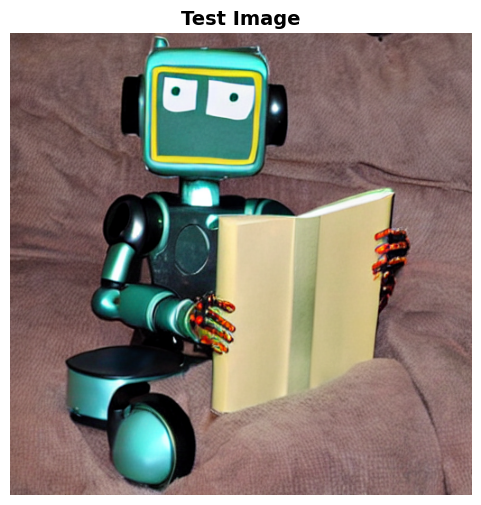

🎨 Generating 'A futuristic city at sunset' in 4 different styles...

Style: Realistic
Generating 1 image(s)...


  0%|          | 0/30 [00:00<?, ?it/s]

 Generated 1 image(s)!
✅ Done!

Style: Artistic
Generating 1 image(s)...


  0%|          | 0/30 [00:00<?, ?it/s]

 Generated 1 image(s)!
✅ Done!

Style: Anime
Generating 1 image(s)...


  0%|          | 0/30 [00:00<?, ?it/s]

 Generated 1 image(s)!
✅ Done!

Style: Oil Painting
Generating 1 image(s)...


  0%|          | 0/30 [00:00<?, ?it/s]

 Generated 1 image(s)!
✅ Done!



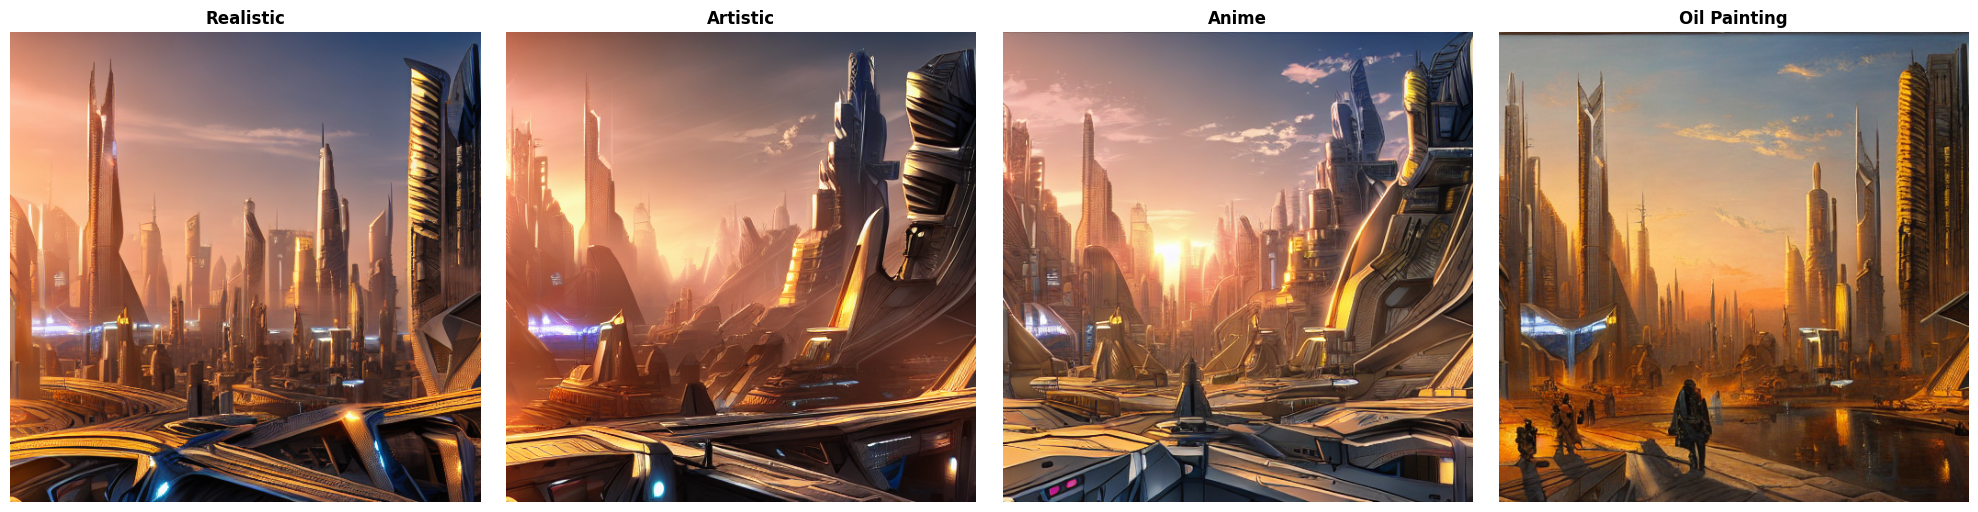

❌ No outputs folder found or it's empty!


In [ ]:
# Test 1: Analyze a prompt
analyze_prompt("a cat")

# Test 2: Quick generation test
quick_test()

# Test 3: Compare styles
compare_styles("A futuristic city at sunset")

# Test 4: Download all your images
download_outputs_as_zip()